In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [2]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import PIL
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense,MaxPool2D,Conv2D,Conv2DTranspose,Conv2D,Conv2DTranspose,BatchNormalization,Input,ReLU,Add,Lambda,LeakyReLU,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow import Tensor
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random

from importlib import reload 
from monk import Dataset
   
from PIL import Image 
import PIL 
  


In [3]:
import ncut_loss
import build_Unet
import build_Wnet
import getData

In [4]:
from datasets import get_damaged_generator
from datasets import get_non_damaged_generator
from datasets import get_mixed_generator
import seaborn as sns
import pandas as pd

In [5]:
from getData import get_generator

# DATASETS

In [6]:
#TRAIN_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_0.json","/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_1.json"]
TEST_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/all_batch_3.json"]


In [7]:
damaged_generator = get_generator(TEST_DATASET,10,256,damaged=True,)
non_damaged_generator = get_generator(TEST_DATASET,10,256,damaged=False,)

In [8]:
non_damaged_samples = non_damaged_generator.__getitem__(2)



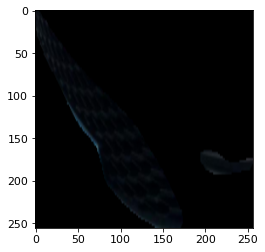

In [9]:
plt.imshow((non_damaged_samples[9]+1)/2)

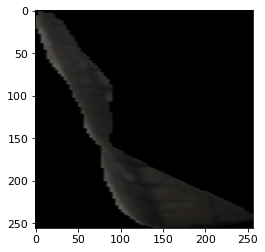

In [10]:
plt.imshow((non_damaged_samples[0]+1)/2)

In [11]:
im = (non_damaged_samples[9]+1)/2

In [14]:
seg = wn.encoder(tf.expand_dims(im,0))

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [30]:
import cv2
img = (np.array((non_damaged_samples[4]+1)/2)*255).astype("uint8")
img_r = cv2.resize(img,(32,32))

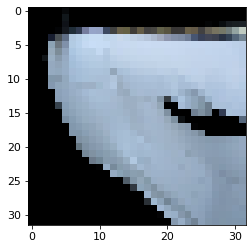

In [31]:
plt.imshow(img_r)

In [ ]:
no_damaged_samples = non_damaged_generator.__getitem__(np.random.randint(1,1000))
plt.figure(figsize=(5,5))
plt.imshow((no_damaged_samples[0]+1)/2)

In [ ]:
print(len(damaged_generator))
print(len(non_damaged_generator))

# MODEL

In [12]:
neighbor_filter=ncut_loss.neighbor_filter((256,256))

In [13]:
#encoder = build_Unet.build_Unet(K=4,stages = [1,2,3,4],filters = 64,type='encoder',input_size=128,use_dropout=False)
#decoder = build_Unet.build_Unet(K=4,stages = [1,2,3,4],filters = 64,type='decoder',input_size=128,use_dropout=False)
#wn = build_Wnet.Wnet(encoder,decoder,(128,128))

K=10
INPUT_DIM=256
USE_DROPOUT=False

encoder = build_Unet.Unet(K=K,type='encoder',input_size=INPUT_DIM,do_dropout=USE_DROPOUT)
decoder = build_Unet.Unet(K=K,type='decoder',input_size=INPUT_DIM,do_dropout=USE_DROPOUT)
wn = build_Wnet.Wnet(encoder,decoder,(INPUT_DIM,INPUT_DIM))


def custom_loss(y_true, y_pred):
    return K.mean(y_true - y_pred)**2

# Compile the model
wn.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.003),
    loss_fn_segmentation = ncut_loss.compute_soft_ncuts,
    loss_fn_reconstruction = tf.keras.losses.MeanSquaredError()
)


In [ ]:
res=wn.encoder(no_damaged_samples)

In [ ]:
res.shape

In [ ]:
wn.encoder.summary()

In [ ]:
wn.load_weights("/home/ubuntu/trainings/damages_classification/2021-06-17-Wnet/WnetDenoiser/ckpt400")



In [ ]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [ ]:
import tensorflow_addons as tfa

def rescale(image):
    return( (((image+1)/2)*255 ).astype("uint8") )


def visualise_seg(image,encoder):
    
    #input_noisy = tfa.image.gaussian_filter2d(image,(10,10),5) + np.random.normal(0, 0.1, image.shape)
    
    sigma=4
    blur_kernel=6
    noise_amp=0.1
    
    image_blurred = tfa.image.gaussian_filter2d( image,(blur_kernel,blur_kernel),sigma)
    noise = np.random.normal(0, noise_amp, image.shape)
    image_blurred = image_blurred + noise
    input_noisy = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)
    
    
    input_noisy = tf.expand_dims(input_noisy, 0)
    #input_noisy = tf.expand_dims(image, 0)
    print(image.shape)
    
    seg = encoder(input_noisy)
    ag = tf.math.argmax(seg, axis=-1, output_type=tf.dtypes.int64)
        
    
    
    
    res_blur = wn.decoder(seg).numpy()[0]
    res_blur = rescale(res_blur)
    
   
    
    plt.figure(figsize=(25,25))

    plt.subplot(1,5,1)
    plt.imshow(rescale(np.array(input_noisy)[0]))
    plt.subplot(1,5,2)
    plt.imshow(ag[0])
    plt.subplot(1,5,3)
    plt.imshow((res_blur))
    plt.subplot(1,5,4)
    plt.imshow(rescale(np.array(image)))
    plt.subplot(1,5,5)
    rgray = ((np.array(res_blur)))
    igray = (rescale(np.array(image)))

    
    a=(rgray-igray)**2
       
    a=np.array(a)
    a=a/a.max()
    a=a*255
    a =a.astype(int)
    #print(a)
    #print(a.max())
    a= np.sum(a,axis=2)


    a=np.array(a,dtype=int)
    plt.imshow(a)
    
    
    return(image,res_blur,seg)

In [ ]:
i,r,seg = visualise_seg(damaged_samples[4],wn.encoder)


In [ ]:
s = np.array(seg[0])
s = np.moveaxis(s, 2, 0)
print(s.shape)



In [ ]:
plt.imshow(ag)

In [ ]:
plt.imshow(np.moveaxis(np.array(seg[0]),2,0)[0])

In [ ]:
plt.imshow(np.moveaxis(np.array(seg[0]),2,0)[1])

In [ ]:
plt.imshow(np.moveaxis(np.array(seg[0]),2,0)[3])

In [ ]:
s = np.moveaxis(np.array(seg[0]),2,0)
ag = tf.math.argmax(s, axis=0, output_type=tf.dtypes.int64)
ag = np.array(ag)
for j in range(10):
    plt.figure()
    
    plt.imshow(np.array(rescale(s[j]))*np.array([ag==j])[0].astype(int))

In [ ]:
seg1 =wn.encoder(tf.expand_dims(no_damaged_samples[3],0))
avg1 = tf.keras.layers.GlobalAveragePooling2D()(seg1)
seg2 =wn.encoder(tf.expand_dims(no_damaged_samples[4],0))
avg2 = tf.keras.layers.GlobalAveragePooling2D()(seg2)
x = np.array([avg1[0],avg2[0]])

print(x.shape)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(x)
print(kmeans.labels_)

In [ ]:
import math

rgray = ((np.array(r)))
igray = (rescale(np.array(i)))
a=(rgray-igray)**2

a=np.array(a)
a=a/a.max()
a=a*255
a =a.astype(int)



a=np.array(a,dtype=int)
a= np.sum(a,axis=2)

plt.figure(figsize=(15,15))
plt.imshow(a)


In [ ]:
ag = visualise_seg(damaged_samples[3],wn.encoder)


In [ ]:
X=[]

for k in range(0,10):
    print(k)
    no_dams = tf.convert_to_tensor(non_damaged_generator.__getitem__(k))   
    dams = tf.convert_to_tensor(damaged_generator.__getitem__(k))
    plt.figure(figsize=(15,15))
    for i in range(0,10):
    
        no_dam=no_dams[i]
        dam=dams[i]

        seg1 = wn.encoder(tf.expand_dims(no_dam,0))
        avg1 = tf.keras.layers.GlobalAveragePooling2D()(seg1)
        seg2 =wn.encoder(tf.expand_dims(dam,0))
        avg2 = tf.keras.layers.GlobalAveragePooling2D()(seg2)

        X.append(avg1[0])
        X.append(avg2[0])

    
X= np.array(X)
    

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1],c=[0,1]*100,alpha=0.7)

# unet

In [ ]:
K=3
decoder = build_Unet.Unet(K=K,type='decoder',input_size=128,do_dropout=False)
decoder.load_weights("/home/ubuntu/trainings/damages_classification/2021-06-17-Wnet/UnetDenoiser/ckpt2000")

In [ ]:
sigma=0.000001
blur_kernel=1
noise_amp=0

import tensorflow_addons as tfa

image =damaged_samples[8]
image_blurred = tfa.image.gaussian_filter2d( image,(blur_kernel,blur_kernel),sigma)
noise = np.random.normal(0, noise_amp, image.shape)
image_blurred = image_blurred + noise
input_noisy = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)


input_noisy = tf.expand_dims(input_noisy, 0)
res=decoder(input_noisy)
plt.imshow(rescale(np.array(res)[0]))

plt.figure()
plt.imshow(((input_noisy[0])+1)/2)

plt.figure()
plt.imshow(((image)+1)/2)

In [ ]:
import math

rgray = rgb2gray((rescale(np.array(res)[0])))
igray = rgb2gray(rescale(np.array(image)))




a=(rgray-igray)**2
print(a.shape)

a=np.array(a)
a=a/a.max()
a=a*255
a =a.astype(int)
#a= np.sum(a,axis=2)


a=np.array(a,dtype=int)

plt.figure(figsize=(15,15))
plt.imshow(a)


In [ ]:
ag = tf.math.argmax(tf.keras.layers.Softmax(axis=-1)(res), axis=-1, output_type=tf.dtypes.int64)

In [ ]:
plt.imshow(ag[0])

In [ ]:
X=[]

for k in range(0,10):
    print(k)
    no_dams = tf.convert_to_tensor(non_damaged_generator.__getitem__(k))   
    dams = tf.convert_to_tensor(damaged_generator.__getitem__(k))
    plt.figure(figsize=(15,15))
    for i in range(0,10):
    
        no_dam=no_dams[i]
        dam=dams[i]

        seg1 = decoder.get_embedding(tf.expand_dims(no_dam,0))
        avg1 = tf.keras.layers.GlobalAveragePooling2D()(seg1)
        seg2 = decoder.get_embedding(tf.expand_dims(dam,0))
        avg2 = tf.keras.layers.GlobalAveragePooling2D()(seg2)

        X.append(avg1[0])
        X.append(avg2[0])

    
X= np.array(X)
    

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1],c=[0,1]*100,alpha=0.7)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1],c=[0,1]*100,alpha=0.7)

# EVAL

In [ ]:
dams_reconstruction = []
no_dams_reconstruction = []

dams_seg = []
no_dams_seg = []

#damaged_generator = get_generator(TEST_DATASET,10,128,damaged=True)
#non_damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False)




sigma=3
blur_kernel=5
noise_amp=0.15

for i in range(0,2):
    print(i)
    no_dams = tf.convert_to_tensor(non_damaged_generator.__getitem__(i))   
    dams = tf.convert_to_tensor(damaged_generator.__getitem__(i))
    for no_dam in no_dams:
      
        input_ = no_dam

        #image_blurred = tfa.image.gaussian_filter2d( no_dam,(blur_kernel,blur_kernel),sigma)
        #noise = np.random.normal(0, noise_amp, no_dam.shape)
        #image_blurred = image_blurred + noise
        #input_noisy = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)
        #input_noisy=tf.expand_dims(input_noisy,0)
        
        input_noisy=tf.expand_dims(input_,0)
  
        

        seg = wn.encoder(input_noisy)
        seg_loss = ncut_loss.compute_soft_ncuts(tf.expand_dims(input_,0),seg,neighbor_filter).numpy()

        reconstruction = wn(input_noisy)
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(tf.expand_dims(input_,0),(reconstruction)).numpy()





        no_dams_reconstruction.append(reconstruction_loss)
        no_dams_seg.append(seg_loss)

    for no_dam in dams:
        input_ = no_dam

        #image_blurred = tfa.image.gaussian_filter2d( no_dam,(blur_kernel,blur_kernel),sigma)
        #noise = np.random.normal(0, noise_amp, no_dam.shape)
        #image_blurred = image_blurred + noise
        #input_noisy = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)
        #input_noisy=tf.expand_dims(input_noisy,0)

        input_noisy=tf.expand_dims(input_,0)

        seg = wn.encoder(input_noisy)
        seg_loss = ncut_loss.compute_soft_ncuts(tf.expand_dims(input_,0),seg,neighbor_filter).numpy()

        reconstruction = wn(input_noisy)
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(tf.expand_dims(input_,0),(reconstruction)).numpy()





        dams_reconstruction.append(reconstruction_loss)
        dams_seg.append(seg_loss)

    

In [ ]:
data = {'damaged':dams_reconstruction,'non damaged':no_dams_reconstruction}
df = pd.DataFrame(data=data)
sns.boxplot(data=df)

In [ ]:
dams_reconstruction = []
no_dams_reconstruction = []

#dams_seg = []
#no_dams_seg = []

#damaged_generator = get_generator(TEST_DATASET,10,128,damaged=True)
#non_damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False)




sigma=5
blur_kernel=10
noise_amp=0.1

for i in range(0,8):
    print(i)
    no_dams = tf.convert_to_tensor(non_damaged_generator.__getitem__(i))   
    dams = tf.convert_to_tensor(damaged_generator.__getitem__(i))
    for no_dam in no_dams:
      
        input_ = no_dam

        image_blurred = tfa.image.gaussian_filter2d( no_dam,(blur_kernel,blur_kernel),sigma)
        noise = np.random.normal(0, noise_amp, no_dam.shape)
        image_blurred = image_blurred + noise
        input_noisy = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)
        input_noisy=tf.expand_dims(input_noisy,0)
        
        #input_noisy=tf.expand_dims(input_,0)
  
        

        

        reconstruction = decoder(input_noisy)
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(tf.expand_dims(input_,0),wn(reconstruction)).numpy()

        no_dams_reconstruction.append(reconstruction_loss)
        

    for no_dam in dams:
        input_ = no_dam

        image_blurred = tfa.image.gaussian_filter2d( no_dam,(blur_kernel,blur_kernel),sigma)
        noise = np.random.normal(0, noise_amp, no_dam.shape)
        image_blurred = image_blurred + noise
        input_noisy = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)
        input_noisy=tf.expand_dims(input_noisy,0)

        #input_noisy=tf.expand_dims(input_,0)

       
        reconstruction = decoder(input_noisy)
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(tf.expand_dims(input_,0),wn(reconstruction)).numpy()





        dams_reconstruction.append(reconstruction_loss)
       

    

In [ ]:
data = {'damaged':dams_reconstruction,'non damaged':no_dams_reconstruction}
df = pd.DataFrame(data=data)
sns.boxplot(data=df)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

X_clf=[]

for i in range(len(no_dams_reconstruction)):
    X_clf.append([no_dams_reconstruction[i],no_dams_seg[i]])
for i in range(len(dams_reconstruction)):
    X_clf.append([dams_reconstruction[i],dams_seg[i]])

X_clf = np.array(X_clf)


y_clf = [0]*20+[1]*20
clf = LogisticRegression()
clf.fit(np.array(X_clf).reshape(-1,2),np.array(y_clf).reshape(-1, 1))

print(clf.score(X_clf,y_clf))


In [ ]:
from sklearn.linear_model import LogisticRegression

X_clf=[]

for i in range(len(no_dams_reconstruction)):
    X_clf.append([no_dams_reconstruction[i]])
for i in range(len(dams_reconstruction)):
    X_clf.append([dams_reconstruction[i]])

X_clf = np.array(X_clf)


y_clf = [0]*80+[1]*80
clf = LogisticRegression()
clf.fit(np.array(X_clf).reshape(-1,1),np.array(y_clf).reshape(-1, 1))

print(clf.score(X_clf,y_clf))


In [ ]:


wn.load_weights("/home/ubuntu/trainings/damages_classification/2021-06-17-Wnet/WnetDropoutIdea/ckpt5300")

In [ ]:
dams_reconstruction = []
no_dams_reconstruction = []

dams_seg = []
no_dams_seg = []

#damaged_generator = get_generator(TEST_DATASET,10,128,damaged=True)
#non_damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False)




sigma=5
blur_kernel=10
noise_amp=0.1

for i in range(0,4):
    print(i)
    no_dams = tf.convert_to_tensor(non_damaged_generator.__getitem__(i))   
    dams = tf.convert_to_tensor(damaged_generator.__getitem__(i))
    for no_dam in no_dams:
      
        input_ = no_dam
        input_=tf.expand_dims(input_,0)


        seg = wn.encoder(input_noisy)
        seg_loss = ncut_loss.compute_soft_ncuts(input_,seg,neighbor_filter).numpy()

        reconstruction = wn(input_)
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(input_,wn(reconstruction)).numpy()



        no_dams_reconstruction.append(reconstruction_loss)
        no_dams_seg.append(seg_loss)

    for no_dam in dams:
        input_ = no_dam

       
        input_=tf.expand_dims(input_,0)

        #plt.imshow(rescale(np.array(input_noisy))[0])

        seg = wn.encoder(input_)
        seg_loss = ncut_loss.compute_soft_ncuts(input_,seg,neighbor_filter).numpy()

        reconstruction = wn(input_)
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(input_,wn(reconstruction)).numpy()

        dams_reconstruction.append(reconstruction_loss)
        dams_seg.append(seg_loss)

    

In [ ]:
data = {'damaged':dams_reconstruction,'non damaged':no_dams_reconstruction}
df = pd.DataFrame(data=data)
sns.boxplot(data=df)

In [ ]:
X_test=[]

for i in range(len(ndams_reco_test)):
    X_test.append([ndams_reco_test[i],ndams_seg_test[i]])
for i in range(len(dams_reco_test)):
    X_test.append([dams_reco_test[i],dams_seg_test[i]])

X_test = np.array(X_test)
print(X_test.shape)

In [ ]:
#X_test = np.array([ndams_reco_test+dams_reco_test,ndams_seg_test+dams_seg_test])
y_test = [0]*51+[1]*51

pred = clf.predict(np.array(X_test).reshape(-1,2))

clf.score(np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))


In [ ]:
#X_test = np.array([ndams_reco_test+dams_reco_test,ndams_seg_test+dams_seg_test])
y_test = [0]*51+[1]*51

pred = clf.predict(np.array(X_test).reshape(-1,2))

clf.score(np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))


In [ ]:
dam = dam_gen.__getitem__(np.random.randint(50,100))
#print(ndam.shape)
plt.figure(figsize=(5,5))
plt.imshow(dam[0])

dam=tf.convert_to_tensor(dam)  
#seg_dam = wn.encoder(dam)
seg_dam = wn.encoder(dam)

#seg_loss_ndam = ncut_loss.compute_soft_ncuts(ndam,seg_ndam,neighbor_filter)


seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
loss_reco = (tf.keras.losses.MeanSquaredError()(dam,wn(dam)).numpy())
print(seg_loss_dam,loss_reco)


clf.predict(np.array([loss_reco,seg_loss_dam]).reshape(1, -1))

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, pred))

# KMEANS

In [ ]:
from scipy.cluster.vq import vq, kmeans, whiten
from sklearn import cluster

In [ ]:
image_rgb = rescale(np.array(damaged_samples[2]))

In [ ]:
image = image_rgb

In [ ]:
kmeans=tf.compat.v1.estimator.experimental.KMeans(image)

In [ ]:


def get_k_mean(image):

    points = image.reshape(image.shape[0]*image.shape[1], -1)

    def input_fn():
        return tf.compat.v1.train.limit_epochs(tf.convert_to_tensor(points, dtype=tf.float32), num_epochs=1)


    num_clusters = 3
    kmeans = tf.compat.v1.estimator.experimental.KMeans(num_clusters=num_clusters, use_mini_batch=False)

    # train
    num_iterations = 10
    previous_centers = None
    for _ in range(num_iterations):
        kmeans.train(input_fn)
        cluster_centers = kmeans.cluster_centers()
        previous_centers = cluster_centers

    # map the input points to their clusters
    cluster_indices = list(kmeans.predict_cluster_index(input_fn))
    
    km=np.array(cluster_centers[cluster_indices]).astype(int).reshape(image.shape[0],image.shape[1], -1)
    return(km)

In [ ]:
km=get_k_mean(rgb2gray(image))

In [ ]:
km.shape
km = ((km/255)*2)-1

In [ ]:
km

In [ ]:
plt.imshow(rgb2gray(image),cmap='gray')

In [ ]:
gray_im = rgb2gray(image)

In [ ]:
gray_im.shape

In [ ]:
x, y = gray_im.shape
image_2d = gray_im.reshape(x*y, 1)
image_2d.shape
kmeans_cluster = cluster.KMeans(n_clusters=3)
kmeans_cluster.fit(image_2d)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_
km = np.array(cluster_centers[cluster_labels]).astype(int).reshape(x, y)

In [ ]:
(((np.array(km)/255)*2)-1).astype(np.float32)

In [ ]:
km.shape

In [ ]:
plt.figure(figsize = (15,8))
plt.imshow(km,cmap='gray')

In [ ]:
import cv2
km= np.array(cluster_centers[cluster_labels]).astype('uint8').reshape(x, y, z)
closing = cv2.morphologyEx(km, cv2.MORPH_CLOSE, (30,30))
closing = cv2.morphologyEx(km,cv2.MORPH_OPEN,(30,30))
closing = cv2.dilate(km,(3,3),iterations = 10)

In [ ]:
plt.figure(figsize = (15,8))
plt.imshow(closing)

In [ ]:
plt.figure(figsize = (15,8))
plt.imshow(np.array(cluster_centers[cluster_labels]).astype(int).reshape(x, y, z))

In [ ]:
np.array(cluster_centers[cluster_labels]).shape

In [ ]:
kmeaned  = np.array(cluster_centers[cluster_labels]).astype(int).reshape(x, y, z)

In [ ]:
((kmeaned/255)*2)-1

In [9]:
# MASK PART
from monk import Dataset, PredictorPipe, cfg_static_default, cfg_inference_default, Image

In [10]:
cfg =  cfg_static_default.clone()
my_pipe = PredictorPipe.from_config(cfg)

In [158]:
img = np.array(((damaged_samples[4]+1)/2)*255).astype("uint8")

In [159]:
image = Image(rgb=img)

In [160]:
res = my_pipe.infer_parts(image)

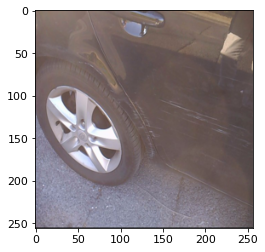

In [161]:
plt.imshow(img)

In [197]:
mask =res.get_masks(["door_back_right"])

mask= mask[0].dilate(1)

Mask(  # shape:(700, 700)
    arr=array([[False, False, False, False, ...,  True,  True,  True,  True],
               [False, False, False, False, ...,  True,  True,  True,  True],
               [False, False, False, False, ...,  True,  True,  True,  True],
               [False, False, False, False, ...,  True,  True,  True,  True],
               ...,
               [False, False, False, False, ..., False, False, False, False],
               [False, False, False, False, ..., False, False, False, False],
               [False, False, False, False, ..., False, False, False, False],
               [False, False, False, False, ..., False, False, False, False]]),
    channel_first=True,
    label='door_back_right',
    attributes={},)


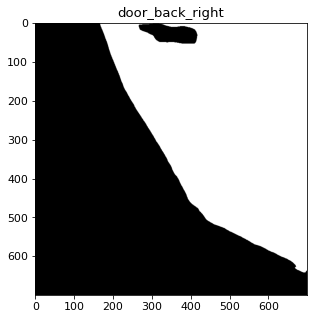

220593 on pixels (45.018980%), 269407 off pixels


In [198]:
mask

In [199]:
i = res.image.arr

In [200]:
mask3d = np.moveaxis(np.array([mask.arr,mask.arr,mask.arr]),0,2)

In [201]:
i_masked = i*mask3d

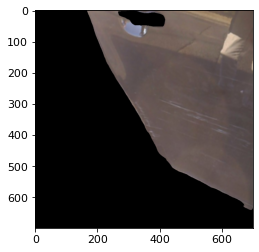

In [202]:
plt.imshow(i_masked)

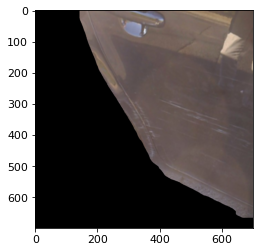

In [196]:
plt.imshow(i_masked)

In [105]:
mask[0]

Array(
    arr=array([False, False, False, False, ..., False, False, False, False]),
    channel_first=True,)

In [106]:
mask[0].dilate(15)

AttributeError: 'Array' object has no attribute 'dilate'

In [88]:
type(mask[0])

monk.structures.masks.Mask

In [99]:
mask.arr.shape

(700, 700)